In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc

2.4.0


Founnd [32] images


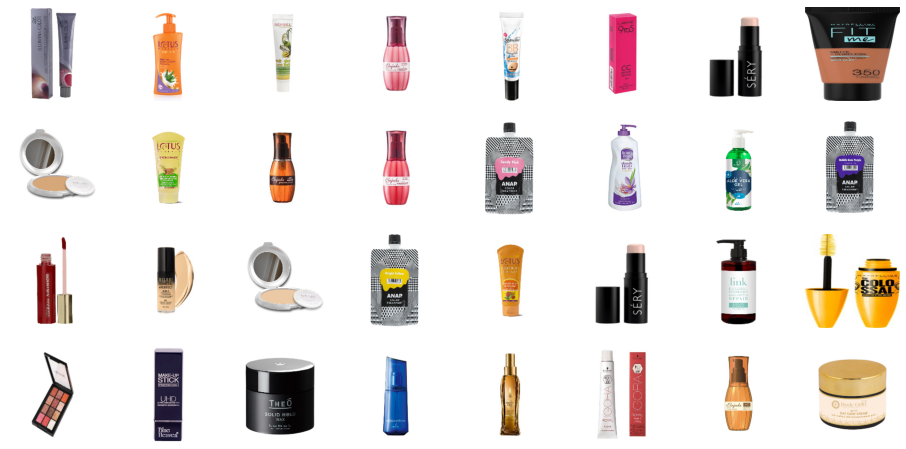

In [2]:
image_paths = glob.glob('C:/Users/User/Desktop/New folder/imageSearch/ProductImages/*.jpg')
print(f'Founnd [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image      

n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

In [3]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  print(img)  
  img = tf.image.resize(img, [400, 400]) 
  img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d) 
  return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
  outputs = [baseline_model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleModel, self).__init__()
    self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # scale back the pixel values
    inputs = inputs*255.0
    # preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # pass through the reduced network
    outputs = self.vgg(preprocessed_input)
    # segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()])


In [4]:
# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths):
    print(image_path)
    image_tensor = load_image(image_path)
    style = style_to_vec(image_to_style(image_tensor))
    image_style_embeddings[ntpath.basename(image_path)] = style

  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\1.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


  3%|██▌                                                                                | 1/32 [00:02<01:23,  2.70s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\10.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(300, 300, 3), dtype=float32)


  6%|█████▏                                                                             | 2/32 [00:03<00:53,  1.78s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\11.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(300, 400, 3), dtype=float32)


  9%|███████▊                                                                           | 3/32 [00:04<00:41,  1.43s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\12.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 12%|██████████▍                                                                        | 4/32 [00:05<00:36,  1.31s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\13.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(300, 300, 3), dtype=float32)


 16%|████████████▉                                                                      | 5/32 [00:07<00:33,  1.23s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\14.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(300, 300, 3), dtype=float32)


 19%|███████████████▌                                                                   | 6/32 [00:08<00:30,  1.17s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\15.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(296, 247, 3), dtype=float32)


 22%|██████████████████▏                                                                | 7/32 [00:09<00:28,  1.16s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\16.jpg
tf.Tensor(
[[[1.         1.         1.        ]
  [0.98823535 0.98823535 0.98823535]
  [1.         1.         1.        ]
  ...
  [0.8470589  0.8470589  0.8470589 ]
  [1.         1.         1.        ]
  [0.9960785  0.9960785  0.9960785 ]]

 [[1.         1.         1.        ]
  [0.9725491  0.9725491  0.9725491 ]
  [0.5921569  0.5921569  0.5921569 ]
  ...
  [0.15294118 0.15294118 0.15294118]
  [0.47058827 0.47058827 0.47058827]
  [0.9921569  0.9921569  0.9921569 ]]

 [[0.92549026 0.92549026 0.92549026]
  [0.43137258 0.43137258 0.43137258]
  [0.12941177 0.12941177 0.12941177]
  ...
  [0.01960784 0.01960784 0.01960784]
  [0.16078432 0.16078432 0.16078432]
  [0.854902   0.854902   0.854902  ]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]

 25%|████████████████████▊                                                              | 8/32 [00:10<00:27,  1.13s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\17.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(800, 800, 3), dtype=float32)


 28%|███████████████████████▎                                                           | 9/32 [00:11<00:25,  1.12s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\18.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(600, 600, 3), dtype=float32)


 31%|█████████████████████████▋                                                        | 10/32 [00:12<00:24,  1.11s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\19.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 34%|████████████████████████████▏                                                     | 11/32 [00:13<00:22,  1.09s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\2.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 38%|██████████████████████████████▊                                                   | 12/32 [00:14<00:21,  1.10s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\20.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 41%|█████████████████████████████████▎                                                | 13/32 [00:15<00:20,  1.09s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\21.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(450, 450, 3), dtype=float32)


 44%|███████████████████████████████████▉                                              | 14/32 [00:16<00:19,  1.08s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\22.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(1000, 880, 3), dtype=float32)


 47%|██████████████████████████████████████▍                                           | 15/32 [00:17<00:18,  1.10s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\23.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 50%|█████████████████████████████████████████                                         | 16/32 [00:18<00:17,  1.08s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\24.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(900, 900, 3), dtype=float32)


 53%|███████████████████████████████████████████▌                                      | 17/32 [00:20<00:16,  1.09s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\25.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(276, 276, 3), dtype=float32)


 56%|██████████████████████████████████████████████▏                                   | 18/32 [00:21<00:15,  1.10s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\26.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(2048, 2048, 3), dtype=float32)


 59%|████████████████████████████████████████████████▋                                 | 19/32 [00:22<00:14,  1.12s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\27.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 62%|███████████████████████████████████████████████████▎                              | 20/32 [00:23<00:14,  1.17s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\28.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(600, 600, 3), dtype=float32)


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:24<00:13,  1.21s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\29.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(296, 247, 3), dtype=float32)


 69%|████████████████████████████████████████████████████████▍                         | 22/32 [00:26<00:12,  1.21s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\3.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 72%|██████████████████████████████████████████████████████████▉                       | 23/32 [00:27<00:10,  1.22s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\30.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(440, 189, 3), dtype=float32)


 75%|█████████████████████████████████████████████████████████████▌                    | 24/32 [00:28<00:09,  1.24s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\31.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(333, 500, 3), dtype=float32)


 78%|████████████████████████████████████████████████████████████████                  | 25/32 [00:29<00:08,  1.23s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\32.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(300, 300, 3), dtype=float32)


 81%|██████████████████████████████████████████████████████████████████▋               | 26/32 [00:31<00:07,  1.23s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\4.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 84%|█████████████████████████████████████████████████████████████████████▏            | 27/32 [00:32<00:06,  1.25s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\5.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 88%|███████████████████████████████████████████████████████████████████████▊          | 28/32 [00:33<00:04,  1.23s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\6.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 91%|██████████████████████████████████████████████████████████████████████████▎       | 29/32 [00:34<00:03,  1.23s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\7.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 94%|████████████████████████████████████████████████████████████████████████████▉     | 30/32 [00:36<00:02,  1.25s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\8.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [00:37<00:01,  1.24s/it]

C:/Users/User/Desktop/New folder/imageSearch/ProductImages\9.jpg
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(500, 500, 3), dtype=float32)


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:38<00:00,  1.21s/it]


In [5]:
image_style_embeddings

{'1.jpg': array([ 1577.4056 ,   504.17825,   606.9164 , ..., 16067.591  ,
        24877.934  , 88102.52   ], dtype=float32),
 '10.jpg': array([   929.9688 ,    225.8587 ,    365.87378, ...,  16645.252  ,
         36532.79   , 130169.34   ], dtype=float32),
 '11.jpg': array([  1093.3505 ,    300.62222,    473.64484, ...,  16157.953  ,
         20643.197  , 102772.375  ], dtype=float32),
 '12.jpg': array([  1151.2416 ,    278.71756,    403.05054, ...,  19606.102  ,
         40293.047  , 100617.01   ], dtype=float32),
 '13.jpg': array([  1308.091 ,    474.1941,    564.6374, ...,  19104.541 ,
         26811.906 , 125540.33  ], dtype=float32),
 '14.jpg': array([   834.50244,    219.15076,    314.04572, ...,  15802.489  ,
         81067.086  , 107254.94   ], dtype=float32),
 '15.jpg': array([ 1600.347  ,   363.39334,   518.2067 , ..., 19419.197  ,
        16252.318  , 84537.3    ], dtype=float32),
 '16.jpg': array([  2196.329  ,    396.25735,    502.4749 , ...,  13019.813  ,
         38843.1

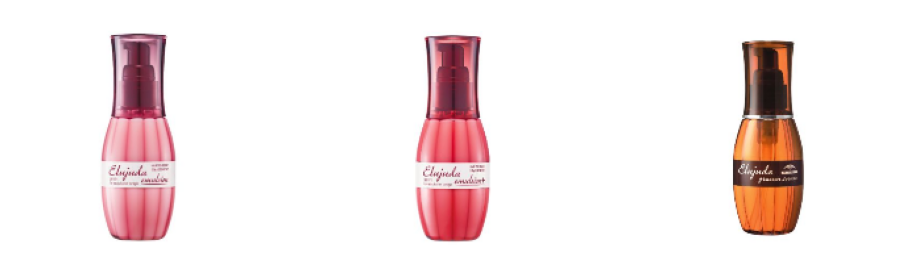

In [7]:
def search_by_style(reference_image, max_results=3):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
    
    plt.show()

# images mostly match the reference style, although not perfectly
search_by_style('12.jpg')

In [9]:
import pickle

# Store data (serialize)
with open('filename.pickle', 'wb') as handle:
    pickle.dump(image_style_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
# Load data (deserialize)
with open('filename.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

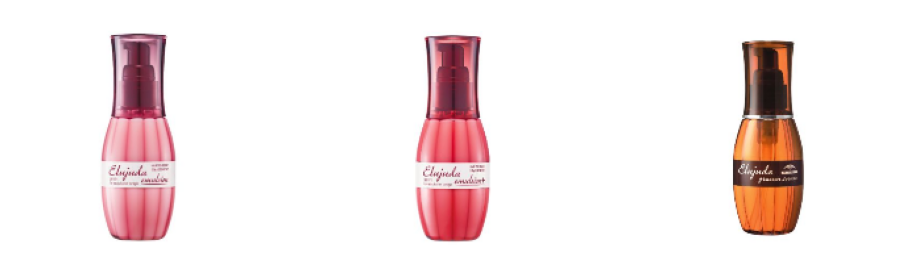

In [12]:
def search_by_style(reference_image, max_results=3):
    v0 = unserialized_data[reference_image]
    distances = {}
    for k,v in unserialized_data.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
    
    plt.show()

# images mostly match the reference style, although not perfectly
search_by_style('12.jpg')

In [ ]:
# compute styles
#image_style_New = {}
image_path="linda1.jpg"
image_tensor = load_image(image_path)
if (image_tensor.shape[3]!= 4):
    style = style_to_vec(image_to_style(image_tensor))
    image_style_embeddings[ntpath.basename(image_path)] = style

In [117]:
image_style_embeddings

{'1 (1).jpg': array([ 1956.3564 ,   310.98257,   502.6564 , ..., 16416.008  ,
        16170.215  , 79246.87   ], dtype=float32),
 '1 (10).jpg': array([  941.503  ,   231.70795,   373.6047 , ..., 11329.894  ,
        11089.67   , 61075.406  ], dtype=float32),
 '1 (11).jpg': array([ 1512.5897 ,   280.51993,   438.4207 , ..., 15781.915  ,
        11001.932  , 70531.32   ], dtype=float32),
 '1 (12).jpg': array([ 1752.2532 ,   310.43427,   488.11545, ..., 16738.424  ,
        16379.261  , 84658.664  ], dtype=float32),
 '1 (13).jpg': array([ 1056.3969 ,   206.16258,   359.06052, ...,  8576.899  ,
        10300.915  , 56489.793  ], dtype=float32),
 '1 (14).jpg': array([ 1833.4152 ,   317.18097,   485.9557 , ..., 17807.8    ,
        17465.184  , 78094.71   ], dtype=float32),
 '1 (15).jpg': array([ 1911.6984 ,   302.85016,   475.4522 , ..., 19325.102  ,
        18376.428  , 94152.016  ], dtype=float32),
 '1 (16).jpg': array([ 2044.05   ,   304.56705,   516.827  , ..., 18673.322  ,
        1857

In [112]:
image = cv2.imread("linda1.jpg", 3)
b,g,r = cv2.split(image)           # get b, g, r
image = cv2.merge([r,g,b])         # switch it to r, g, b
image = cv2.resize(image, (200, 200))
images[ntpath.basename("linda1.jpg")] = image

In [11]:
# TETETETETETETS
image_style_New = {}
image_tensor = load_image("linda3.jpg")
if (image_tensor.shape[3]!= 4):
    style = style_to_vec(image_to_style(image_tensor))
    image_style_New[ntpath.basename("linda3.jpg")] = style

tf.Tensor(
[[[0.07450981 0.07450981 0.08235294]
  [0.09411766 0.09411766 0.10196079]
  [0.09803922 0.09803922 0.10588236]
  ...
  [0.08235294 0.07843138 0.09803922]
  [0.07843138 0.07450981 0.09803922]
  [0.08235294 0.07843138 0.10196079]]

 [[0.1137255  0.1137255  0.12156864]
  [0.03529412 0.03529412 0.04313726]
  [0.07843138 0.07843138 0.08627451]
  ...
  [0.07843138 0.07450981 0.09411766]
  [0.07843138 0.07450981 0.09803922]
  [0.07843138 0.07450981 0.09803922]]

 [[0.07843138 0.07843138 0.08627451]
  [0.07058824 0.07058824 0.07843138]
  [0.12156864 0.12156864 0.12941177]
  ...
  [0.09019608 0.08627451 0.10588236]
  [0.09019608 0.08627451 0.10980393]
  [0.08627451 0.08235294 0.10588236]]

 ...

 [[0.03137255 0.02745098 0.04705883]
  [0.01568628 0.01176471 0.03137255]
  [0.04705883 0.04313726 0.0627451 ]
  ...
  [0.02745098 0.02352941 0.04313726]
  [0.02745098 0.02352941 0.04313726]
  [0.03137255 0.02745098 0.04705883]]

 [[0.03137255 0.02745098 0.04705883]
  [0.01176471 0.00784314 0

In [12]:
#TETETETTEETETTES
image_style_New

{'linda3.jpg': array([ 1417.9746 ,   264.77744,   380.43246, ..., 14451.617  ,
        14466.978  , 63413.746  ], dtype=float32)}

In [13]:
#TETETETETETETETETS
def search_by_style(reference_image, max_results=3):
    #gathering info of ref img
    v0 = image_style_New[reference_image]
    print(v0)
    distances = {}
    #finding sortest distance with/in image_style_embeddings
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    print(sorted_neighbors[:max_results])
    
    #f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    #for i, img in enumerate(sorted_neighbors[:max_results]):
        #ax[i].imshow(images[img[0]])
        #ax[i].set_axis_off()
    
    #plt.show()

# images mostly match the reference style, although not perfectly
search_by_style('linda3.jpg')

[ 1417.9746    264.77744   380.43246 ... 14451.617   14466.978
 63413.746  ]
[('linda1.jpg', 0.0), ('linda2.jpg', 0.007841408252716064), ('1 (11).jpg', 0.12151670455932617)]


In [122]:
def search_by_style(reference_image, max_results=2):
    v0 = image_style_embeddings[reference_image]
    print(v0)
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    print(sorted_neighbors[:max_results])
    
    #f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    #for i, img in enumerate(sorted_neighbors[:max_results]):
        #ax[i].imshow(images[img[0]])
        #ax[i].set_axis_off()
    
    #plt.show()

# images mostly match the reference style, although not perfectly
search_by_style('linda1.jpg')

[ 1417.9746    264.77744   380.43246 ... 14451.617   14466.978
 63413.746  ]
[('linda1.jpg', 0.0), ('linda2.jpg', 0.007841408252716064)]
